# Memoria M0_2 c) Localizar cruz (punto 1)

## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
import matplotlib
from PIL import Image

## Load csv data

In [3]:
# Read csv file
df = pd.read_csv('./anotaciones1.csv', sep='; ',header=None)
df.columns = ['folder','fname','point','coordinates']
print('Size:  ',df.shape)
df.head()

Size:   (1479, 4)


/home/irene/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


folder                              fname point  \
0  REY_roi_manualSelection1    ROI_0_Psic_205Ev4.pdf_pg-70.jpg    a1    
1  REY_roi_manualSelection1    ROI_0_Psic_101Ev5.pdf_pg-27.jpg    a1    
2  REY_roi_manualSelection1   ROI_90_Psic_029Ev4.pdf_pg-24.jpg    a1    
3  REY_roi_manualSelection1    ROI_0_Psic_516Ev3.pdf_pg-26.jpg    a1    
4  REY_roi_manualSelection1    ROI_0_Psic_131Ev5.pdf_pg-25.jpg    a1    

  coordinates  
0   (34,24) ;  
1   (27,41) ;  
2   (37,33) ;  
3   (39,41) ;  
4   (29,41) ;

### Select only the a1 point

In [4]:
new_df = df.loc[df['point']=='a1 ']
new_df.shape

(304, 4)

## Load images

In [5]:
img_h, img_w = 500,500 #desired dimensions
reduct = 0.6 # reduction factor
redim_vec = [it*reduct for it in [img_w,img_h]] # vector used to scale dimensions

### Preprocessing

In [6]:
# add white pixels to fit all images into the same size
def adjust_dims(img,b,r):
    size = img.shape[:2]
    color = [255,255,255]
    bottom = b-size[0]
    right = r-size[1]
    out_img = cv2.copyMakeBorder(img, 0,bottom,0,right,cv2.BORDER_CONSTANT,value=color)
    return out_img

# reduce images size
from skimage.transform import rescale, resize
def reduce_imgs(img, reduct):
    img = resize(img, (img.shape[0]*reduct, img.shape[1]*reduct), anti_aliasing=False)
    return img

# thresholding gray images
from skimage.filters import threshold_otsu
def thresh_imgs(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

In [7]:
path = './REY_DATASET/REY_roi_manualSelection1/'
# path = './REY_DATASET/REY_c/'
imgs,boxes = [],[]
for name in os.listdir(path):
    if name+' ' in new_df['fname'].values:
        # Labels
        label = new_df['coordinates'].loc[new_df['fname']==name+' '].values[0]
#         print('Image: ',name, ' with  label:   ',label)

        # Images
        img = cv2.imread(path+name)
        AR = img.shape[0]/img.shape[1]
#         print('                         dimensions: ',img.shape,'     -----------  AR: {0:0.2f}'.format(AR))
        
        if AR<1.4 and img.shape[0] < img_w and img.shape[1] < img_h:
            img = adjust_dims(img,img_h,img_w) # desired dimensions
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
            gray = thresh_imgs(gray) # convert into binary image
            gray = reduce_imgs(gray, reduct) # reduce size to fit the network
            gray = gray.astype('float32')

            imgs.append(gray)
            boxes.append(label)
    
    
#     plt.imshow(gray), plt.show()
num_imgs = len(imgs)
print('Number of images added: ',num_imgs)

Number of images added:  239


### Redimensionate labels

In [8]:
y = np.zeros((num_imgs,2))
for i,bb in enumerate(boxes):
    aux = bb.strip(' ;').strip('(').strip(')').split(',')
    y[i] = [float(a) for a in aux] # extract vector of two dimensions
y = y *reduct /redim_vec # adjust to actual image size
y.shape

(239, 2)

### Redimensionate images dataset

In [9]:
X = np.stack(imgs)

print('Shape of image set: ',X.shape)

Shape of image set:  (239, 300, 300)


### Reshape images to enter the model

In [10]:
X_ = np.repeat(X[..., np.newaxis], 1, -1)   # set one channel

X_.shape

(239, 300, 300, 1)

In [11]:
y_ = y.reshape(num_imgs,-1)

y_.shape

(239, 2)

### Plot annotation

In [12]:
plt.figure(figsize=(12,3))
plt.imshow(X[0]*255, cmap='gray', interpolation='none', origin='lower')#, extent=[0,img_w,0,img_h])
a = y_[0]*redim_vec
plt.gca().add_patch(plt.Circle((a[0], a[1]), 3, color='r'))

### Split train and test dataset

In [13]:
i = int(0.8*num_imgs)
X_train = X_[:i]
X_test = X_[i:]
y_train = y_[:i]
y_test = y_[i:]

print('Size of training set:  ',X_train.shape[0])
print('Size of testing set:  ',X_test.shape[0])

Size of training set:   191
Size of testing set:   48


## Keras Neural Network

In [14]:
# Build the model.
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [15]:
def model_conv(X_,y_):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu', 
                     input_shape=X_.shape[1:]))
    model.add(Conv2D(filters=8, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(y_.shape[-1]))

    model.summary()
    model.compile('adadelta','mse')
    return model

model = model_conv(X_,y_)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 8)       80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)            

In [ ]:
from keras.applications import imagenet_utils
from keras.applications import VGG16

def model_vgg(X_,y_):
    model = VGG16(weights="imagenet", include_top=False, # use without the classifier
                  input_shape=X_.shape[1:]) 
    
    x = Flatten()(model.output)
    x = Dense(1024, activation='relu')(x)
#     x = Dense(512, activation='relu')(x)
    x = Dense(y_.shape[-1])(x) # activation relu gives 0, because the values tend to negatives
    
    new_model = Model(input=model.input, output=x)
    
    new_model.summary() 
    new_model.compile('adadelta','mse')
    return new_model

# model = model_vgg(X_,y_)

In [16]:
# Train.
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=2)

Train on 191 samples, validate on 48 samples
Epoch 1/20
 - 12s - loss: 5.4563 - val_loss: 0.0101
Epoch 2/20
 - 12s - loss: 0.0223 - val_loss: 9.7446e-04
Epoch 3/20
 - 12s - loss: 0.0133 - val_loss: 0.0023
Epoch 4/20
 - 12s - loss: 0.0126 - val_loss: 9.9734e-04
Epoch 5/20
 - 12s - loss: 0.0121 - val_loss: 0.0011
Epoch 6/20
 - 12s - loss: 0.0096 - val_loss: 0.0010
Epoch 7/20
 - 12s - loss: 0.0098 - val_loss: 0.0011
Epoch 8/20
 - 12s - loss: 0.0067 - val_loss: 0.0011
Epoch 9/20
 - 12s - loss: 0.0064 - val_loss: 9.1685e-04
Epoch 10/20
 - 12s - loss: 0.0057 - val_loss: 0.0023
Epoch 11/20
 - 12s - loss: 0.0058 - val_loss: 0.0013
Epoch 12/20
 - 12s - loss: 0.0049 - val_loss: 0.0011
Epoch 13/20
 - 12s - loss: 0.0042 - val_loss: 9.1202e-04
Epoch 14/20
 - 12s - loss: 0.0037 - val_loss: 9.7787e-04
Epoch 15/20
 - 12s - loss: 0.0031 - val_loss: 0.0022
Epoch 16/20
 - 12s - loss: 0.0055 - val_loss: 0.0029
Epoch 17/20
 - 12s - loss: 0.0032 - val_loss: 0.0017
Epoch 18/20
 - 12s - loss: 0.0023 - val_los

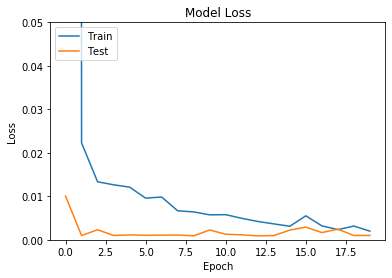

In [18]:
# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,0.05])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Predict

In [19]:
model.save_weights('./ensayos_cross_localize/weights_cross_localize_4.h5')

In [20]:
model_json = model.to_json()
with open("./ensayos_cross_localize/model_cross_localize_4.json", "w") as json_file:
    json_file.write(model_json)

In [21]:
# Predict point coordinates on the test images.
pred_y = model.predict(X_test)
pred_points = (pred_y *redim_vec) /reduct # * (reduct*img_w)
pred_points.shape

(48, 2)

### Show detected points

In [22]:
plt.figure(figsize=(12,3))
for i_subplot in range(1, 5):

    i = np.random.randint(len(X_test))
    B = X_test[i]
    B = np.repeat(B[...],3,-1) # convert to three dimensional
    a = pred_points[i]
    print(a)
    
    plt.subplot(1, 4, i_subplot)
    plt.imshow(B, cmap='gray', interpolation='none', origin='lower', extent=[0,img_w,0,img_h])
    plt.gca().add_patch(plt.Circle((a[0], a[1]), 10, color='r'))

[47.8917025  57.74886534]
[47.09097743 60.06445736]
[40.0082171  46.14553973]
[41.1487408  45.94846442]


### Calculate mean error

In [23]:
summed_mse = 0
test_points = y_test*redim_vec/ reduct
for pred_p, test_p in zip(pred_points, test_points):
    summed_mse += np.sqrt((pred_p[0]-test_p[0])**2 + (pred_p[1]-test_p[1])**2)
mse = summed_mse / len(pred_points)
print('Final error:  ',mse)

Final error:   19.538537421148398
